# Testing Human VAE

In [1]:
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
import numpy as np
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '3'
import pbdlib as pbd

from datetime import datetime

import networks
import config
from utils import *
import dataloaders

torch.autograd.set_detect_anomaly(True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [2]:
train_iterator = dataloaders.buetepage_downsampled.SequenceWindowDataset('./data/buetepage/traj_data.npz', train=True, window_length=40)
test_iterator = dataloaders.buetepage_downsampled.SequenceWindowDataset('./data/buetepage/traj_data.npz', train=False, window_length=40)

z_dim = 3
nb_dim = 2*z_dim
z_trajs = np.load('z_trajs.npz', allow_pickle=True)['arr_0']
nb_states = 6
hsmm = [pbd.HMM(nb_dim=nb_dim, nb_states=nb_states) for a in range(len(train_iterator.actidx))]

for a in [2]:#range(len(train_iterator.dataset.actidx)):
    hsmm[a].init_hmm_kbins(z_trajs[a])
    hsmm[a].em(z_trajs[a])

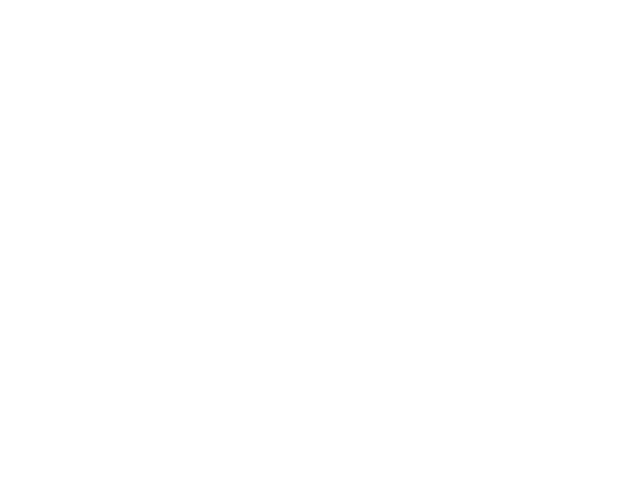

In [3]:
%matplotlib widget
import matplotlib.pyplot as plt
from utils import *
import asyncio

fig = plt.figure()
axs = []
async def update():
    global axs, fig, hsmm
    for i in [2]:
        ax = fig.add_subplot(1,1,1, projection='3d')
        pbd.plot_gmm3d(ax, hsmm[i].mu[:,:3], hsmm[i].sigma[:,:3,:3], color='r')
        pbd.plot_gmm3d(ax, hsmm[i].mu[:,3:], hsmm[i].sigma[:,3:,3:], color='b')
        z_traj = z_trajs[i][0][::2]
        seq_len = z_traj.shape[0]
        z2_pred,_ = hsmm[i].condition(z_traj[:, :z_dim], None, dim_in=slice(0, z_dim), dim_out=slice(z_dim, 2*z_dim))
        z1_pred,_ = hsmm[i].condition(z_traj[:, z_dim:], None, dim_in=slice(z_dim, 2*z_dim), dim_out=slice(0, z_dim))
        for t in range(0,seq_len,5):
            ax.scatter(z_traj[t, 0], z_traj[t, 1], z_traj[t, 2], color='r', marker='o')
            ax.scatter(z_traj[t, 3], z_traj[t, 4], z_traj[t, 5], color='b', marker='o')
            # ax.scatter(z1_pred[t, 0], z1_pred[t, 1], z1_pred[t, 2], color='r', marker='*')
            ax.scatter(z2_pred[t, 0], z2_pred[t, 1], z2_pred[t, 2], color='b', marker='*')
            # ax.plot([z_traj[t, 0], z1_pred[t, 0]], [z_traj[t, 1], z1_pred[t, 1]], zs=[z_traj[t, 2], z1_pred[t, 2]], color='r')
            ax.plot([z_traj[t, 3], z2_pred[t, 0]], [z_traj[t, 4], z2_pred[t, 1]], zs=[z_traj[t, 5], z2_pred[t, 2]], color='b')
            fig.canvas.draw_idle()
            fig.canvas.flush_events()
            await asyncio.sleep(0.01)
loop = asyncio.get_event_loop()
loop.create_task(update());